In [484]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import time

In [485]:
# Seed the randomness and set the device to GPU if available
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [486]:
# Get the data, normalize it and put it in a DataLoader
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [487]:
# Define the network architecture (LeNet-ish)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, padding=3)
        self.pool = nn.MaxPool2d(stride=2, kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=4096, out_features=10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv4((F.relu(self.conv3(x))))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        # x = F.softmax(x, dim=1) # softmax is not needed here, as it is included in the loss function (gives lower accuracy)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=10, bias=True)
)

In [488]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=0.001, amsgrad=True)

In [489]:
# Train the network

training_time = np.array([])
testing_error = np.array([])
epochs = np.array([])
total_time = 0

training_error = np.array([])

for epoch in tqdm(range(30)):  # set the number of epochs

    time_before_epoch = time.time()

    for i, data in tqdm(enumerate(train_loader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    time_after_epoch = time.time() - time_before_epoch
    total_time += time_after_epoch
    training_time = np.append(training_time, total_time)
    epochs = np.append(epochs, epoch)

    # Training error
    correct = 0
    total = 0

    with torch.no_grad():
        for data in train_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            # calculate the test loss
            train_loss = criterion(outputs, labels)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    training_error = np.append(training_error, 100 - 100 * correct // total)

    # Test the network
    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            # calculate the test loss
            test_loss = criterion(outputs, labels)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    testing_error = np.append(testing_error, 100 - 100 * correct // total)

    print(f'Accuracy after {epoch + 1} epochs: {100 * correct // total} %')

print('Finished Training')

782it [00:03, 215.82it/s]:00<?, ?it/s]
  3%|▎         | 1/30 [00:06<03:22,  6.97s/it]

Accuracy after 1 epochs: 27 %


782it [00:03, 222.45it/s]
  7%|▋         | 2/30 [00:13<03:14,  6.94s/it]

Accuracy after 2 epochs: 36 %


782it [00:03, 217.82it/s]
 10%|█         | 3/30 [00:20<03:08,  6.97s/it]

Accuracy after 3 epochs: 42 %


782it [00:03, 218.49it/s]
 13%|█▎        | 4/30 [00:27<03:00,  6.95s/it]

Accuracy after 4 epochs: 44 %


782it [00:03, 218.87it/s]
 17%|█▋        | 5/30 [00:34<02:53,  6.93s/it]

Accuracy after 5 epochs: 43 %


782it [00:03, 211.65it/s]
 20%|██        | 6/30 [00:41<02:47,  6.97s/it]

Accuracy after 6 epochs: 50 %


782it [00:03, 214.95it/s]
 23%|██▎       | 7/30 [00:48<02:41,  7.01s/it]

Accuracy after 7 epochs: 50 %


782it [00:03, 217.44it/s]
 27%|██▋       | 8/30 [00:55<02:33,  6.99s/it]

Accuracy after 8 epochs: 54 %


782it [00:03, 219.46it/s]
 30%|███       | 9/30 [01:02<02:25,  6.95s/it]

Accuracy after 9 epochs: 54 %


782it [00:03, 221.38it/s]
 33%|███▎      | 10/30 [01:09<02:19,  6.96s/it]

Accuracy after 10 epochs: 56 %


782it [00:03, 214.08it/s]
 37%|███▋      | 11/30 [01:16<02:12,  6.98s/it]

Accuracy after 11 epochs: 58 %


782it [00:03, 217.43it/s]
 40%|████      | 12/30 [01:23<02:06,  7.00s/it]

Accuracy after 12 epochs: 58 %


782it [00:03, 212.07it/s]
 43%|████▎     | 13/30 [01:30<01:59,  7.03s/it]

Accuracy after 13 epochs: 61 %


782it [00:03, 214.77it/s]
 47%|████▋     | 14/30 [01:37<01:52,  7.02s/it]

Accuracy after 14 epochs: 64 %


782it [00:03, 217.89it/s]
 50%|█████     | 15/30 [01:44<01:45,  7.01s/it]

Accuracy after 15 epochs: 63 %


782it [00:03, 219.40it/s]
 53%|█████▎    | 16/30 [01:51<01:37,  6.98s/it]

Accuracy after 16 epochs: 64 %


782it [00:03, 216.28it/s]
 57%|█████▋    | 17/30 [01:58<01:30,  6.99s/it]

Accuracy after 17 epochs: 66 %


782it [00:03, 215.10it/s]
 60%|██████    | 18/30 [02:05<01:24,  7.02s/it]

Accuracy after 18 epochs: 66 %


782it [00:03, 214.39it/s]
 63%|██████▎   | 19/30 [02:12<01:16,  6.99s/it]

Accuracy after 19 epochs: 67 %


782it [00:03, 222.73it/s]
 67%|██████▋   | 20/30 [02:19<01:09,  6.95s/it]

Accuracy after 20 epochs: 65 %


782it [00:03, 219.03it/s]
 70%|███████   | 21/30 [02:26<01:02,  6.96s/it]

Accuracy after 21 epochs: 69 %


782it [00:03, 218.58it/s]
 73%|███████▎  | 22/30 [02:33<00:55,  6.96s/it]

Accuracy after 22 epochs: 70 %


782it [00:03, 216.38it/s]
 77%|███████▋  | 23/30 [02:40<00:48,  6.97s/it]

Accuracy after 23 epochs: 69 %


782it [00:03, 209.88it/s]
 80%|████████  | 24/30 [02:47<00:42,  7.03s/it]

Accuracy after 24 epochs: 69 %


782it [00:03, 213.98it/s]
 83%|████████▎ | 25/30 [02:54<00:35,  7.02s/it]

Accuracy after 25 epochs: 71 %


782it [00:03, 216.46it/s]
 87%|████████▋ | 26/30 [03:01<00:28,  7.04s/it]

Accuracy after 26 epochs: 70 %


782it [00:03, 211.27it/s]
 90%|█████████ | 27/30 [03:08<00:21,  7.09s/it]

Accuracy after 27 epochs: 71 %


782it [00:03, 217.71it/s]
 93%|█████████▎| 28/30 [03:16<00:14,  7.08s/it]

Accuracy after 28 epochs: 71 %


782it [00:03, 217.58it/s]
 97%|█████████▋| 29/30 [03:22<00:07,  7.03s/it]

Accuracy after 29 epochs: 70 %


782it [00:03, 212.13it/s]
100%|██████████| 30/30 [03:29<00:00,  7.00s/it]

Accuracy after 30 epochs: 70 %
Finished Training


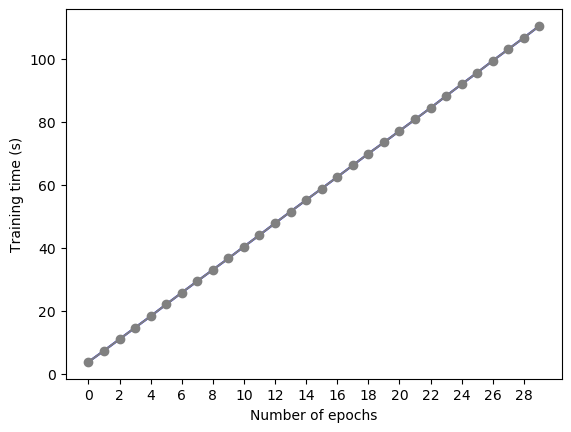

In [490]:
# Plot the training time
plt.plot(epochs, training_time, color='blue')
plt.plot(epochs, training_time, color='gray', marker='o')
plt.xlabel('Number of epochs')
plt.ylabel('Training time (s)')
# Force the x-axis to be integers
plt.xticks(np.arange(0, epochs[-1] + 1, 2))
plt.show()

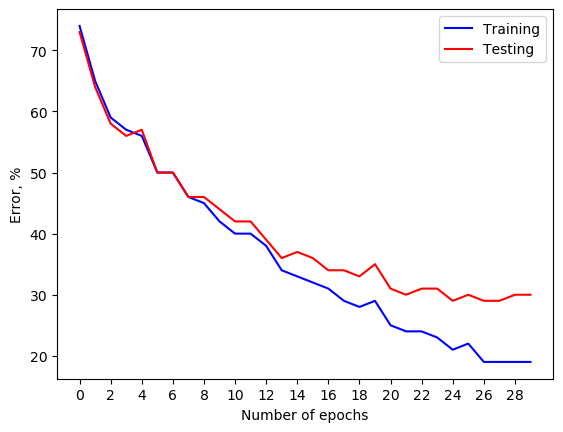

In [491]:
# Plot the training error and testing accuracy
plt.plot(epochs, training_error, label='Training', color='blue')
plt.plot(epochs, testing_error, label='Testing', color='red')
plt.xlabel('Number of epochs')
plt.ylabel('Error, %')
plt.legend()
# Force the x-axis to be integers
plt.xticks(np.arange(0, epochs[-1] + 1, 2))
plt.show()